# Module 7: Calculating mPDF patterns from ferromagnets and ferrimagnets

This example demonstrates how to calculate the mPDF for a magnetic structure with a net magnetic moment, such as a ferromagnet or ferrimagnet. It is very similar to calculating the mPDF for an antiferromagnet, but there is one quick extra step that needs to be taken.

### Import necessary modules

In [2]:
### Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt

from diffpy.mpdf import *
from diffpy.structure import loadStructure

### Set all plots to be inline
%matplotlib notebook

## Example: Ferromagnetic MnSb

Like usual, we start by loading in a CIF file.

In [4]:
cif = "files/MnSb.cif"
struc = loadStructure(cif)
print(struc)

lattice=Lattice(a=4.149, b=4.149, c=5.771, alpha=90, beta=90, gamma=120)
Mn   0.000000 0.000000 0.000000 1.0000
Mn   0.000000 0.000000 0.500000 1.0000
Sb   0.333333 0.666667 0.250000 1.0000
Sb   0.666667 0.333333 0.750000 1.0000


Now we create a MagSpecies object and set the propagation vector to (0, 0, 0), corresponding to a ferromagnetic structure. Then we'll load it into a MagStructure object and run makeAll() to generate the atoms and spins.

In [5]:
mspec = MagSpecies(struc, strucIdxs=[0,1], ffparamkey='Mn3', rmaxAtoms=40,
                   basisvecs=np.array([0,0,1]), kvecs=np.array([0,0,0]))

mstruc = MagStructure(rmaxAtoms=40)
mstruc.loadSpecies(mspec)
mstruc.makeAll()
print(mstruc.spins[:10]) # verify the ferromagnetic arrangement

[[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


Here is where things get a little different for materials with a net magnetic moment: the calculated mPDF should include a linear term proportional to the number density of magnetic moments and the average net moment per magnetic ion. By default, these quantities (MagStructure.rho0 and MagStructure.netMag) are set to 0 in a MagStructure object, so if we calculate the mPDF without first setting these values, then we will have an incorrect calculation. Let's take a look at that:

<IPython.core.display.Javascript object>


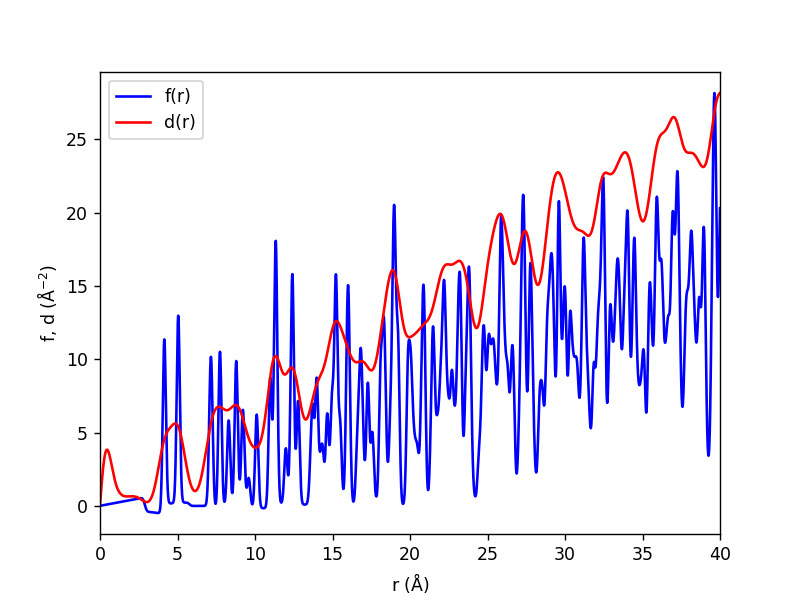

In [6]:
mc = MPDFcalculator(mstruc, rmax=40)
mc.plot(both=True)

You'll notice that peak overlap causes the mPDF to increase with r. This is because we are not correctly including the linear term with the default rho0 and netMag values. Fortunately, we can set those values automatically using the methods shown below, or we could also set them manually if necessary.

In [7]:
# set the rho0 attribute
print('Initial number density: ', mstruc.rho0)
mstruc.calcAtomicDensity()
print('New number density: ', mstruc.rho0)


# set the netMag attribute
print('Initial net magnetic moment: ', mstruc.netMag)
mstruc.calcNetMag() # consult documentation for different options for this function
print('New net magnetic moment: ', mstruc.netMag)
# Note that the net moment is 2 muB, since our spin vectors are of unit magnitude
# and we are multiplying by a Lande g factor of 2, as is appropriate for magnetic
# moments with no orbital component.

Initial number density:  0
New number density:  0.023246705831713944
Initial net magnetic moment:  0
New net magnetic moment:  2.0


Now the mPDF calculation will work correctly. Note that it now oscillates around zero, as it should.

<IPython.core.display.Javascript object>


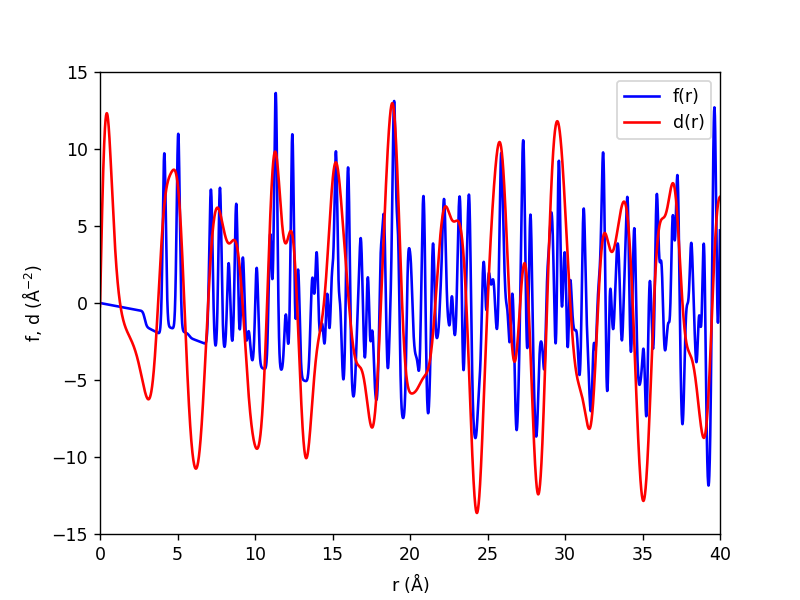

In [8]:
mc.plot(both=True)

In [9]:
plt.close('all')

Note that it also works in the case of a finite correlation length:

<IPython.core.display.Javascript object>


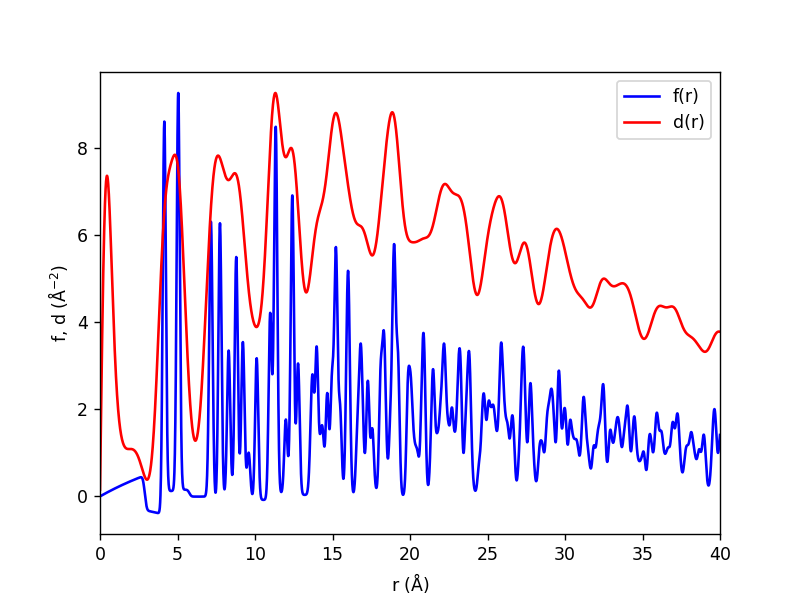

<IPython.core.display.Javascript object>


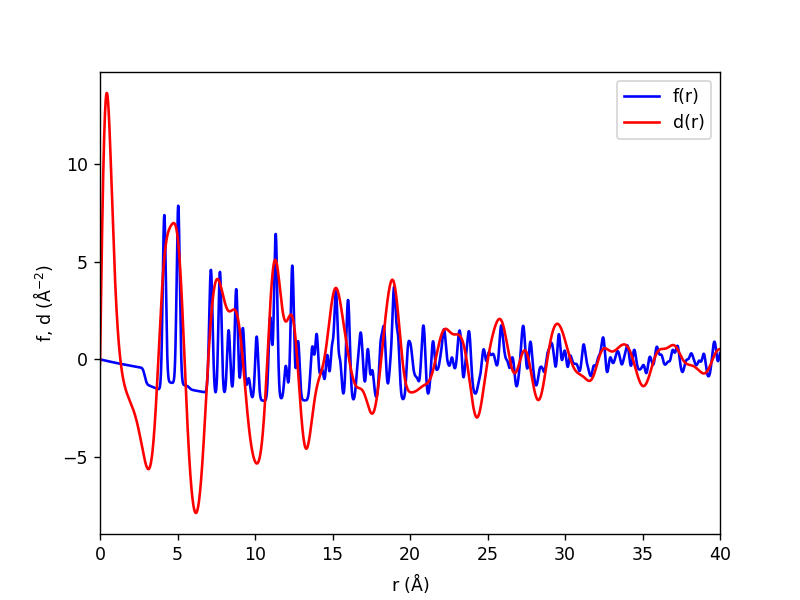

In [10]:
mstruc.corrLength = 15.0

# incorrect calculation for comparison
mstruc.rho0 = 0
mstruc.netMag = 0
mc.plot(both=True)

# correct calculation
mstruc.calcAtomicDensity()
mstruc.calcNetMag()
mc.plot(both=True)

In [11]:
plt.close('all')

## Example: Ferrimagnet

Now let's pretend that MnSb is a ferrimagnet, with one of the Mn sites have a smaller magnetic moment and aligned opposite the other. Because the moments do not cancel perfectly, this structure still has a net magnetic moment, so we need to remember to set rho0 and netMag correctly.

lattice=Lattice(a=4.149, b=4.149, c=5.771, alpha=90, beta=90, gamma=120)
Mn   0.000000 0.000000 0.000000 1.0000
Mn   0.000000 0.000000 0.500000 1.0000
Sb   0.333333 0.666667 0.250000 1.0000
Sb   0.666667 0.333333 0.750000 1.0000


<IPython.core.display.Javascript object>


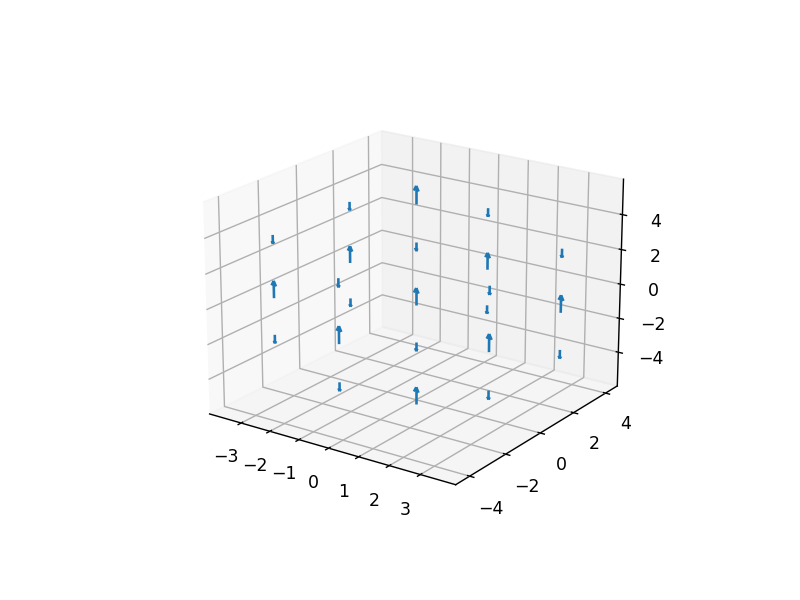

In [13]:
cif = "files/MnSb.cif"
struc = loadStructure(cif)
print(struc)

# We need two different MagSpecies for this ferrimagnetic structure.
svec1 = np.array([0,0,1])
svec2 = np.array([0,0,-0.5])
mspec1 = MagSpecies(struc, strucIdxs=[0], ffparamkey='Mn3', rmaxAtoms=40,
                   basisvecs=svec1, kvecs=np.array([0,0,0]))

mspec2 = MagSpecies(struc, strucIdxs=[1], ffparamkey='Mn3', rmaxAtoms=40,
                   basisvecs=svec2, kvecs=np.array([0,0,0]))


mstruc = MagStructure(rmaxAtoms=40)
mstruc.loadSpecies(mspec1)
mstruc.loadSpecies(mspec2)
mstruc.makeAll()

# Let's check that it looks right.
visMask = np.apply_along_axis(np.linalg.norm, 1, mstruc.atoms - mstruc.atoms[0]) < 6
visAtoms = mstruc.atoms[visMask]
visSpins = mstruc.spins[visMask]
mstruc.visualize(visAtoms, visSpins)

Now we set rho0 and netMag. Just for practice, can you predict what netMag should be? It's the net magnetic moment in Bohr magnetons per magnetic atom, so you can find the average spin vector and multiply that by the g factor (2 unless you have set it to something different).

0.5


<IPython.core.display.Javascript object>


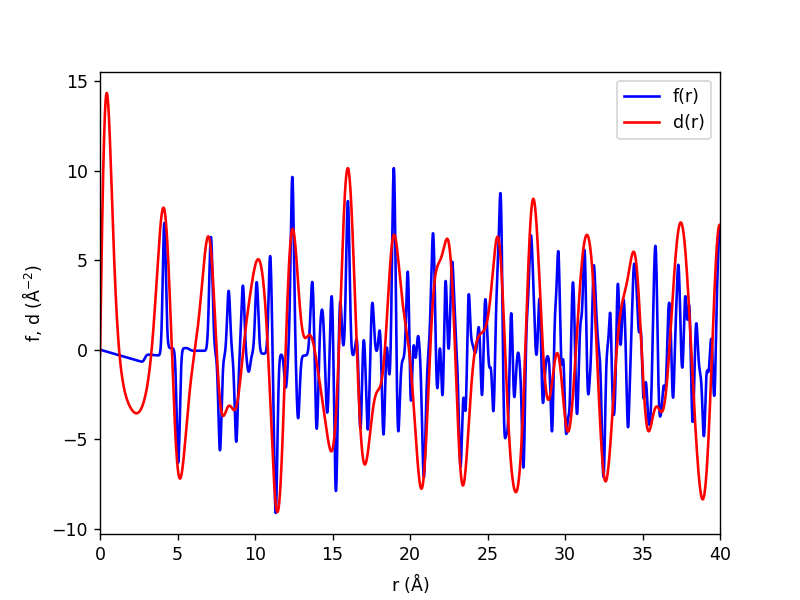

In [16]:
mstruc.calcAtomicDensity()
mstruc.netMag = 0.25 * 2 # make your prediction; use the lines below if you want to check your work

mstruc.calcNetMag()
print(mstruc.netMag)

mc = MPDFcalculator(mstruc, rmax=40)
mc.plot(both=True)

In [17]:
plt.close('all')

## If you are feeling lazy: automatic linear correction

If, for some reason, you don't want to or can't set the rho0 and netMag attributes, you can just let the program estimate the best linear contribution that keeps the mPDF oscillating around 0. You do this by setting the linearTermMethod argument to 'autoslope' in MPDFcalculator.calc() and/or MPDFcalculator.plot(), as shown below. This is an accurate and reliable option in the vast majority of cases.

lattice=Lattice(a=4.149, b=4.149, c=5.771, alpha=90, beta=90, gamma=120)
Mn   0.000000 0.000000 0.000000 1.0000
Mn   0.000000 0.000000 0.500000 1.0000
Sb   0.333333 0.666667 0.250000 1.0000
Sb   0.666667 0.333333 0.750000 1.0000


<IPython.core.display.Javascript object>


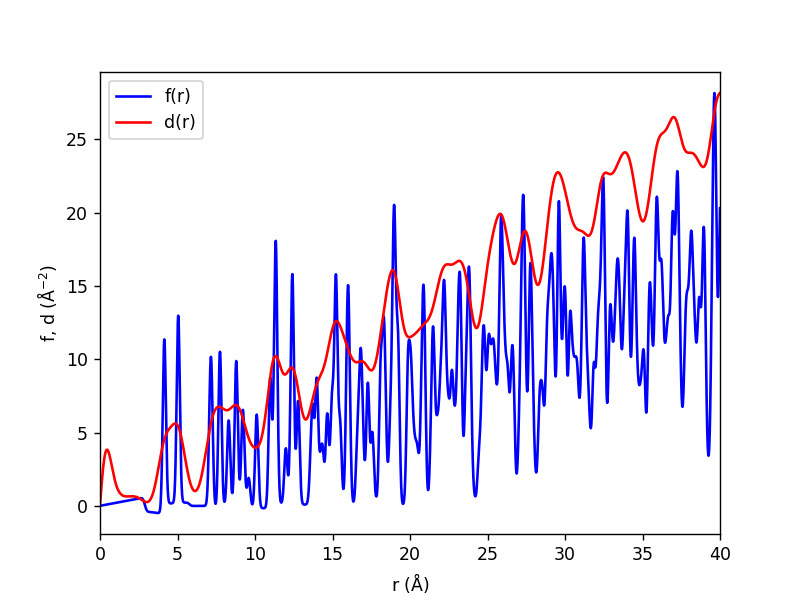

<IPython.core.display.Javascript object>


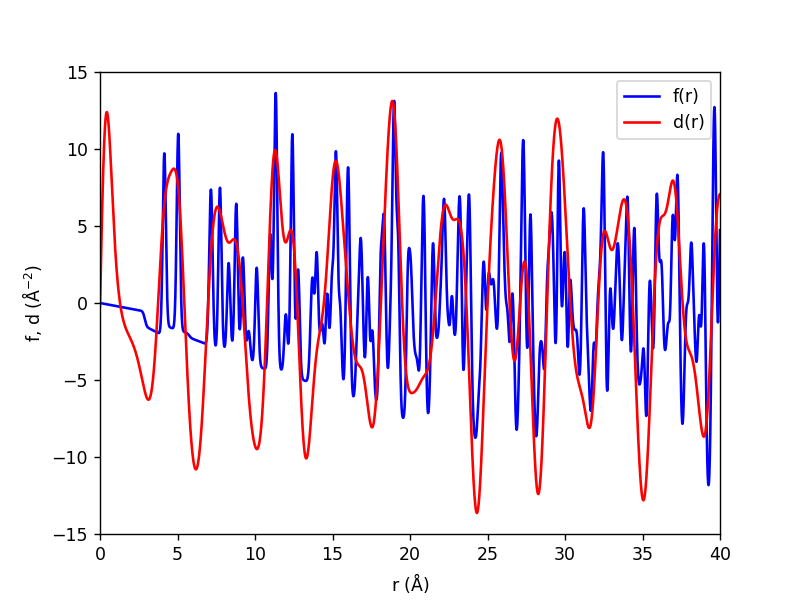

In [18]:
cif = "files/MnSb.cif"
struc = loadStructure(cif)
print(struc)

mspec = MagSpecies(struc, strucIdxs=[0,1], ffparamkey='Mn3', rmaxAtoms=40,
                   basisvecs=np.array([0,0,1]), kvecs=np.array([0,0,0]))

mstruc = MagStructure(rmaxAtoms=40)
mstruc.loadSpecies(mspec)
mstruc.makeAll()

mc = MPDFcalculator(mstruc, rmax=40)
# incorrect calculation
mc.plot(both=True)
# corrected calculation
mc.plot(both=True, linearTermMethod='autoslope')

In [19]:
plt.close('all')

## Esoteric example: Anisotropic correlation lengths in a ferro/ferrimagnet

If you encounter a situation where a ferro or ferrimagnet has an anisotropic correlation length (e.g. a longer correlation length in certain directions than in other directions), then it can be a little bit tricky to get the linear component of the mPDF just right. Currently, the best practice is to use the 'fullauto' option for the linearTermMethod argument of MPDFcalculator.calc(). This is demonstrated below.

In [20]:
cif = "files/MnSb.cif"
struc = loadStructure(cif)
print(struc)

mspec = MagSpecies(struc, strucIdxs=[0,1], ffparamkey='Mn3', rmaxAtoms=40,
                   basisvecs=np.array([0,0,1]), kvecs=np.array([0,0,0]))

mstruc = MagStructure(rmaxAtoms=40)
mstruc.loadSpecies(mspec)
mstruc.makeAll()

lattice=Lattice(a=4.149, b=4.149, c=5.771, alpha=90, beta=90, gamma=120)
Mn   0.000000 0.000000 0.000000 1.0000
Mn   0.000000 0.000000 0.500000 1.0000
Sb   0.333333 0.666667 0.250000 1.0000
Sb   0.666667 0.333333 0.750000 1.0000


Now we impose an anisotropic correlation length using the MagStructure.dampingMat attribute. This is a 3x3 symmetric matrix for which the eigenvalues are equal to the inverse squared correlation length along the direction given by the corresponding eigenvector. See the appendix of https://doi.org/10.1107/S1600576722007257 for more details. Note also that we pass a non-default value for the correlationMethod argument of MPDFcalculator.calc() (see documentation for more details).

<IPython.core.display.Javascript object>


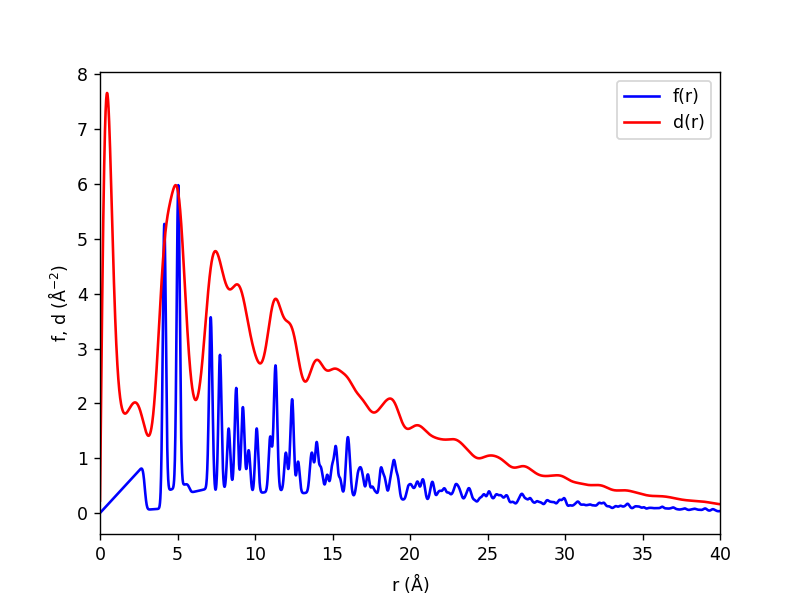

/home/benfrandsen/miniconda3/envs/diffpy/lib/python3.7/site-packages/diffpy.mpdf-1.0.0-py3.7.egg/diffpy/mpdf/magstructure.py:946: RuntimeWarning: invalid value encountered in true_divide
  distanceVecsN = distanceVecs/np.apply_along_axis(np.linalg.norm,1,distanceVecs)[:,np.newaxis]


<IPython.core.display.Javascript object>


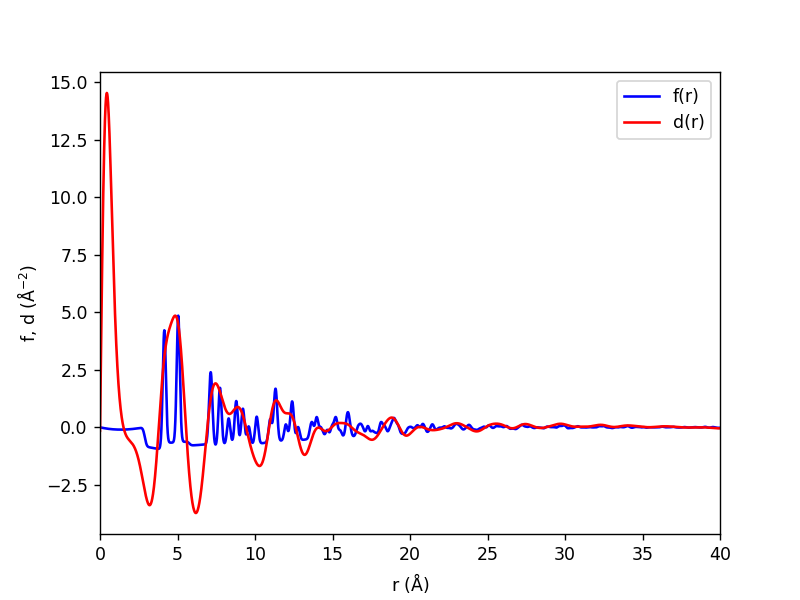

In [21]:
xi_c = 20.0 # correlation length along c axis
xi_ab = 5.0 # correlation length in the ab plane
mstruc.dampingMat = np.array([[1/xi_ab**2, 0, 0],[0, 1/xi_ab**2, 0],[0, 0, 1/xi_c**2]])

mc = MPDFcalculator(mstruc, rmax=40)
# incorrect calculation
mc.plot(both=True, correlationMethod='full')
# corrected calculation
mc.plot(both=True, correlationMethod='full', linearTermMethod='fullauto')

In [22]:
plt.close('all')